In [2]:
!pip install opencv-python

  Using cached opencv_python-4.5.5.62-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.4 MB)


In [3]:
!pip install --upgrade tensorflow-hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)


In [4]:
"""!mkdir ./model_efficientdet_d6_1
!tar xzf "./efficientdet_d6_1.tar.gz" -C ./model_efficientdet_d6_1
"""

'!mkdir ./model_efficientdet_d6_1\n!tar xzf "./efficientdet_d6_1.tar.gz" -C ./model_efficientdet_d6_1\n'

In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pathlib

import matplotlib
import cv2
import io
import scipy.misc
import numpy as np
from six import BytesIO
from six.moves.urllib.request import urlopen
import time

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [3]:
path_annotrain = "../datasets/datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)

bbox_train_full = train_annotation.loc[:, ["im_name", "x_min", "y_min", "x_max", "y_max"]]

im_test = bbox_train_full.iloc[1, 0] ##Récupére le path du fichier
x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]#Renvois les coordonées

In [4]:
def load_plot(im_name, x1, y1, x2, y2):

    im = np.asanyarray(Image.open(f"../datasets/datasets_train/train/{im_name}"))

    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

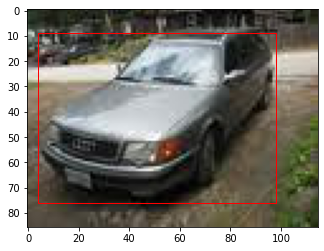

In [5]:
load_plot(im_test, x1, y1, x2, y2)

In [6]:
detector = hub.load("./model_efficientdet_d6_1")

In [7]:
def get_image_path(path):
    imagee = Image.open(path)
    im = np.asanyarray(imagee)
    rgb_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)
    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor , 0)
    return rgb_tensor

In [8]:
imagee = Image.open(f"../datasets/datasets_train/train/{im_test}")
im = np.asanyarray(imagee)
rgb_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)

#Add dims to rgb_tensor
rgb_tensor = tf.expand_dims(rgb_tensor , 0)
# running inference
res = detector(rgb_tensor)

In [9]:
res["detection_classes"].numpy()

array([[ 8.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  8.,  3.,
         3.,  6.,  8.,  3.,  3.,  3.,  3.,  8.,  3.,  3.,  3.,  3.,  3.,
         8.,  3.,  3.,  8.,  6.,  8.,  3.,  3.,  3.,  3.,  3.,  8.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  6.,  3.,  8.,  3.,  8.,
         3.,  3.,  1.,  3.,  3.,  3.,  3.,  6.,  3.,  3.,  3.,  3.,  8.,
         8.,  6.,  3.,  3.,  8.,  3.,  3.,  6.,  3.,  8., 64.,  3.,  3.,
         3.,  8.,  3.,  6.,  8.,  3.,  8.,  3.,  3.,  8.,  3.,  3.,  3.,
         3.,  6.,  8., 15.,  3.,  3.,  8.,  3.,  3.]], dtype=float32)

In [10]:
#Mapping category numbers to labels
category_to_label = pd.read_csv('labels.csv', sep=';', index_col='ID')
category_to_label = category_to_label['OBJECT (2017 REL.)']

In [11]:
def get_output_of_prediction(prediction, height, width):
    classes = prediction['detection_classes'].numpy().astype('int')[0]
    boxes = prediction["detection_boxes"].numpy()
    scores = prediction["detection_scores"].numpy()
    best_car_score = 0
    best_box = None
    for score,(ymin,xmin,ymax,xmax) , label in zip(scores[0], boxes[0], classes):
        if score > 0.4:
            if category_to_label[label] == "car" or  category_to_label[label] == "truck" :
                if score > best_car_score : 
                    best_car_score = score
                    best_box = (ymin,xmin,ymax,xmax)
    
    if best_box : 
        ymin,xmin,ymax,xmax = best_box
        return xmin * width ,ymin * height, xmax * width , ymax * height, best_car_score
    else:
        return None

In [12]:
imagee.size

(115, 86)

In [13]:
xmin, ymin, xmax, ymax, score = get_output_of_prediction(res, imagee.size[1], imagee.size[0])       
#except : 
#    print("There is no car or truck in this image")

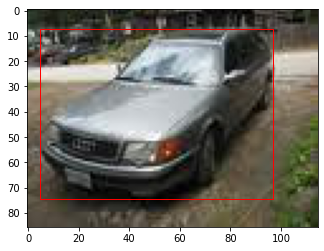

In [14]:
load_plot(im_test, xmin, ymin, xmax, ymax)

In [15]:
print("Bounding Box calculated with our model {:.2f}, {:.2f}, {:.2f} , {:.2f}".format(xmin, ymin, xmax, ymax))

Bounding Box calculated with our model 4.79, 7.21, 96.95 , 74.67


In [16]:
 print("Bounding Box calculated with our model {:.2f}, {:.2f}, {:.2f} , {:.2f}".format(x1, y1, x2, y2))

Bounding Box calculated with our model 4.00, 9.00, 98.00 , 76.00


In [17]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2
    intersect_w = _interval_overlap([xmin1, xmax1], [xmin2, xmax2])
    intersect_h = _interval_overlap([ymin1, ymax1], [ymin2, ymax2])
    intersect = intersect_w * intersect_h
    w1, h1 = xmax1-xmin1, ymax1-ymin1
    w2, h2 = xmax2-xmin2, ymax2-ymin2
    union = w1*h1 + w2*h2 - intersect
    iou =  float(intersect) / union
    if iou != iou :
        return 0
    return iou

In [18]:
bbox_iou((xmin, ymin, xmax, ymax), (x1, y1, x2, y2))

0.9363144096842436

In [19]:
def MAPE (y_pred, y):
    return np.abs(y_pred - y) / y_pred

MAPE(0.2, 0.35)

0.7499999999999998

## Testing the already trained model on our training data (unobserved) :  

0


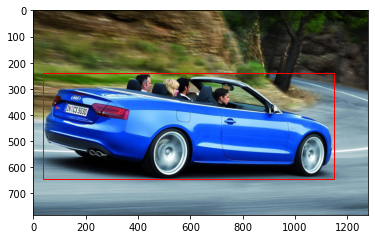

IOU :  0.9586357703108931
mean IOU :  0.9586357703108931
1


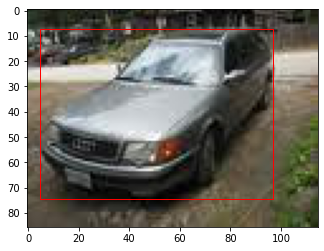

IOU :  0.9363144096842436
mean IOU :  0.9474750899975684
2


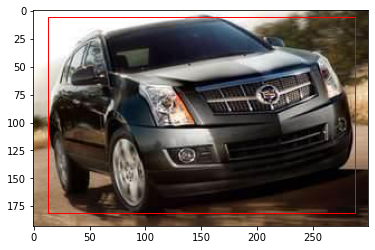

IOU :  0.9300794617507654
mean IOU :  0.941676547248634
3


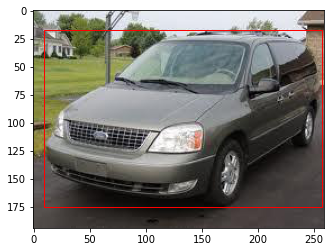

IOU :  0.9162664261878007
mean IOU :  0.9353240169834257
4


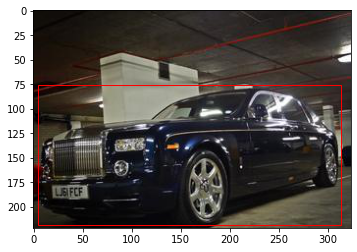

IOU :  0.9166885769915594
mean IOU :  0.9315969289850525
5


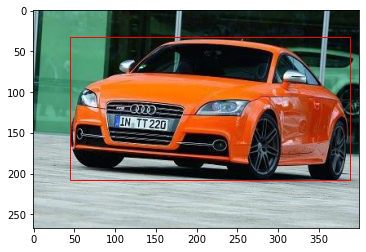

IOU :  0.9302929753251468
mean IOU :  0.9313796033750682
6


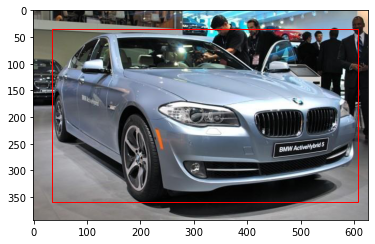

IOU :  0.9712859338541369
mean IOU :  0.9370805077292209
7


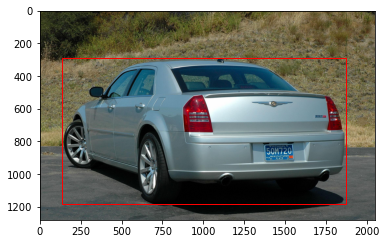

IOU :  0.9849561909442396
mean IOU :  0.9430649681310982
8


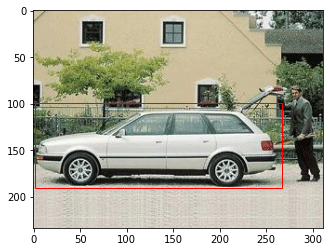

IOU :  0.8185918297208059
mean IOU :  0.9292346194188436
9


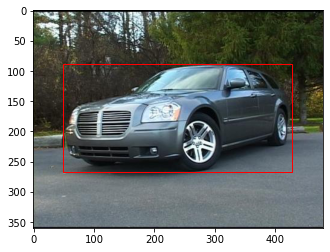

IOU :  0.9578933715027698
mean IOU :  0.9321004946272362
10


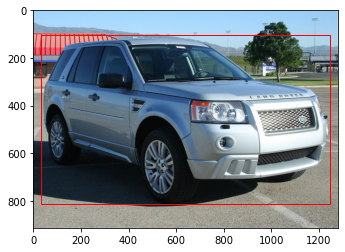

IOU :  0.9530362379792654
mean IOU :  0.9340037440228752
11


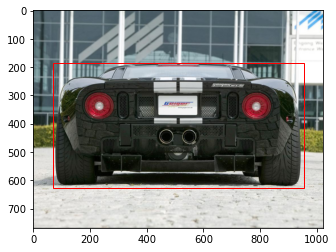

IOU :  0.9583685787421319
mean IOU :  0.9360341469161466
12


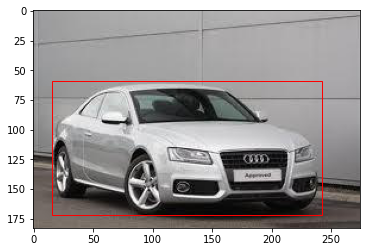

IOU :  0.9592197443903223
mean IOU :  0.9378176544141602
13


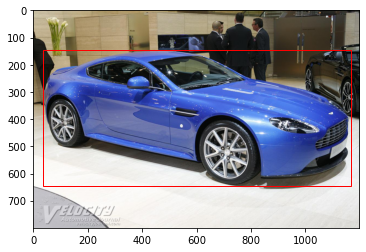

IOU :  0.8729443676166236
mean IOU :  0.9331838482143361
14


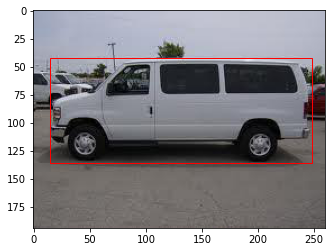

IOU :  0.9353512431562403
mean IOU :  0.9333283412104632
15


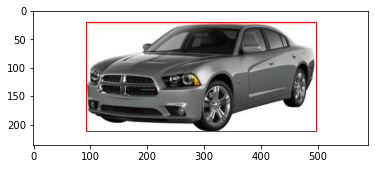

IOU :  0.95045414629519
mean IOU :  0.9343987040282585
16


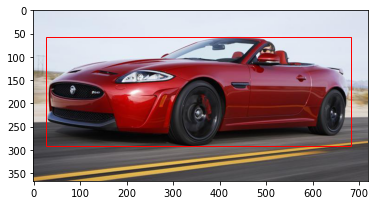

IOU :  0.990648503097531
mean IOU :  0.9377075157382158
17


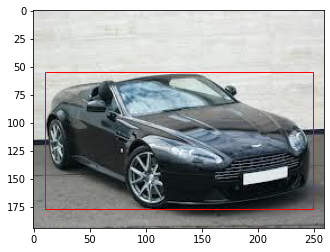

IOU :  0.9516576713875983
mean IOU :  0.9384825243854037
18


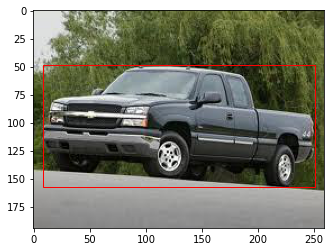

IOU :  0.9459933095803773
mean IOU :  0.9388778288693497
19


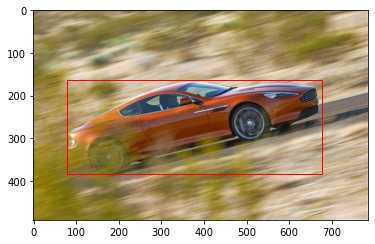

IOU :  0.9629648859684804
mean IOU :  0.9400821817243064
20


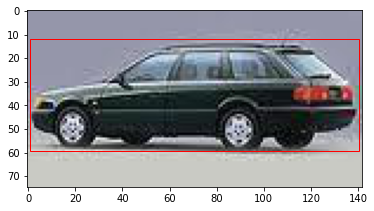

IOU :  0.8793240190931819
mean IOU :  0.937188935884729
21


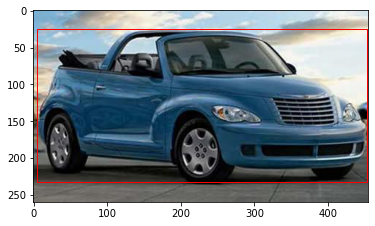

IOU :  0.9742826514498498
mean IOU :  0.9388750138649619
22


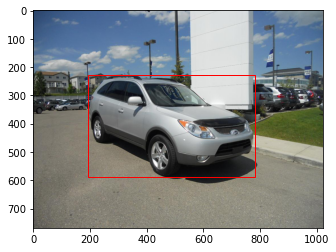

IOU :  0.9761391064256069
mean IOU :  0.9404951918023812
23


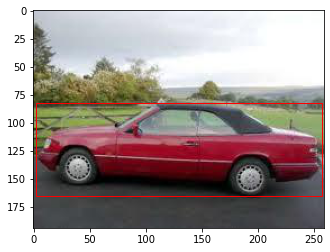

IOU :  0.9030910147733743
mean IOU :  0.9389366844261725
24


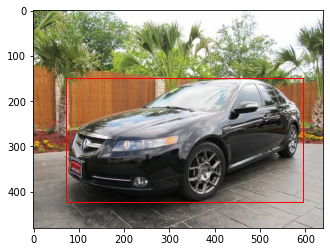

IOU :  0.9664380550183426
mean IOU :  0.9400367392498593
25


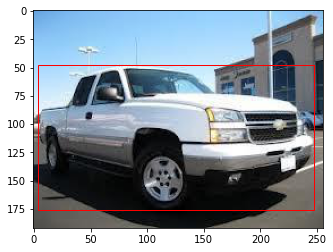

IOU :  0.8555114016695793
mean IOU :  0.9367857647275408
26


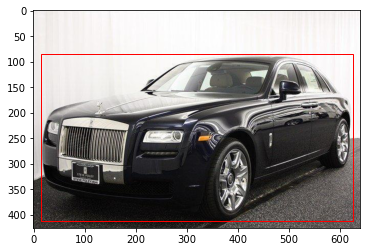

IOU :  0.9643326336337839
mean IOU :  0.9378060191314758
27


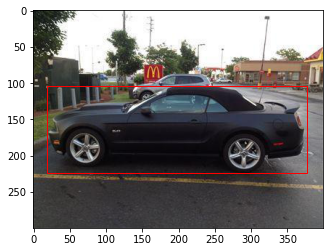

IOU :  0.9740315095289724
mean IOU :  0.9390997866456721
28


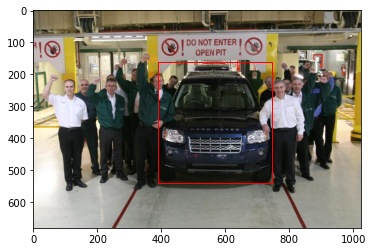

IOU :  0.8891201513498653
mean IOU :  0.9373763509458166
29


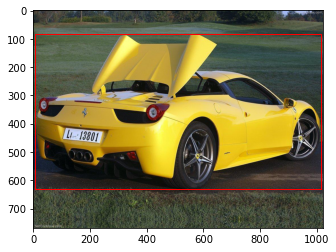

IOU :  0.9772732561380799
mean IOU :  0.9387062477855588
30


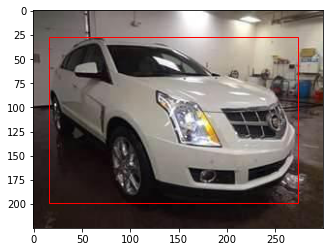

IOU :  0.9788421806545277
mean IOU :  0.940000955297461
31


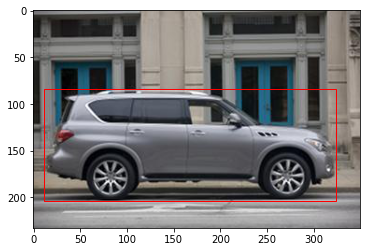

IOU :  0.946894063301921
mean IOU :  0.9402163649226004
32


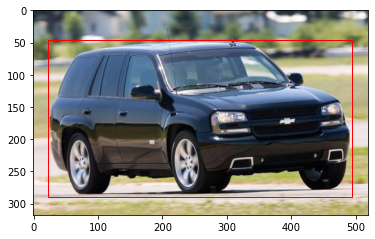

IOU :  0.902963088293136
mean IOU :  0.9390874777520105
33


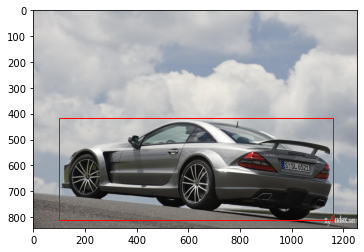

IOU :  0.9739323229780921
mean IOU :  0.9401123261410129
34


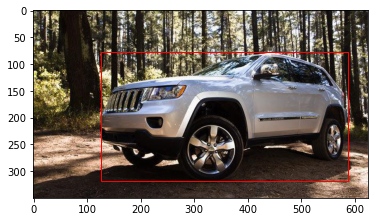

IOU :  0.9496326803008425
mean IOU :  0.9403843362598652
35


In [ ]:
image_names = bbox_train_full.iloc[:,0]
cpt = 0
mean_IOU = 0
start = time.time()
IOU  = []
errors = 0
for imag in image_names:
    print(cpt)
    if cpt == 1000:
        break
    cpt+=1
    try : 
        tensor = get_image_path(f"../datasets/datasets_train/train/{imag}")
        results_ = detector(tensor)
        x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == imag].iloc[0, 1:]
        try : 
            xmin, ymin, xmax, ymax, score = get_output_of_prediction(results_, tensor.shape[1], tensor.shape[2]) 

        except : 
            print("There is no car or truck in this image")
        else:
            load_plot(imag, xmin, ymin, xmax, ymax)
            iou = bbox_iou((xmin, ymin, xmax, ymax), (x1, y1, x2, y2))
            if iou == iou :#and iou !=0:
                print("IOU : ", iou)
                mean_IOU += iou
                print("mean IOU : ", mean_IOU/cpt)
            else:
                errors += 1
                print("problème avec",imag, iou)
    except:
        errors+=1
        print("error while processing image {}".format(imag))
    
end = time.time()
print("Execution time : {:.2}".format(end-start))        
print("Number of errors : ", errors)
mean_IOU = mean_IOU/cpt
mean_IOU